## Projeto Final - PPgEEC - Aprendizado de Máquina

#### Componentes:
 - José Augusto Agripino de Oliveira
 - Luiz Henrique Araújo Dantas


Objetivo do projeto: Avaliação de desempenho de modelo através de transfer learning pelas técnicas de Feature Extractor e Fine-tuning

Modelo selecionado: VGG16

Dataset selecionado: [Bone Fracture Multi-Region X-ray Data](https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data)


Este conjunto de dados compreende imagens de raios X fraturadas e não fraturadas cobrindo todas as regiões anatômicas do corpo, incluindo membros inferiores, membros superiores, lombar, quadris, joelhos, etc. O conjunto de dados é categorizado em pastas de treinamento, teste e validação, cada uma contendo imagens radiográficas fraturadas e não fraturadas.

Quantidade de imagens disponibilizadas: 10.580 imagens

Divisão do conjunto de dados:

- Dados de treinamento: 9246 imagens

- Dados de validação: 828 imagens

- Dados de teste: 506 imagens

In [ ]:
%pip install torch torchvision torchaudio pandas seaborn numpy kagglehub > install_logs.txt

In [ ]:
import os
import math
import time
import torch
import pandas
import seaborn
import kagglehub
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import ImageFile
from copy import deepcopy
from torchvision import models, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.v2 import Compose, ToImage, Normalize, CenterCrop, Resize, ToDtype

In [ ]:
print(torch.__version__)

2.5.1+cu121


In [ ]:
# Download latest version
path = kagglehub.dataset_download("bmadushanirodrigo/fracture-multi-region-x-ray-data")

print("Path to dataset files:", path)

100%|██████████| 481M/481M [00:06<00:00, 75.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/versions/2


In [ ]:
# Lista todos os arquivos e diretórios baixados
data_directory = os.path.join(path, "Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification")
entries = os.listdir(data_directory)
print("Arquivos no diretório:", entries)

Arquivos no diretório: ['train', 'val', 'test']


In [ ]:
#Instanciando modelo VGG16
torch.manual_seed(42)

vgg16 = models.vgg16(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = vgg16.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# DataLoaders

A média e o desvio padrão utilizado para normalizar as imagens do dataset escolhido para este trabalho precisam ser os mesmo utilizado para o dataset de treinamento do VGG16. O ImageNet é um banco de dados de imagens organizado de acordo com a hierarquia WordNet (atualmente apenas os substantivos), em que cada nó da hierarquia é representado por centenas e milhares de imagens.

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256),
  CenterCrop(224),
  ToImage(),
  ToDtype(torch.float32, scale=True),
  normalizer])

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Carrega os dados de treinamento
train_data = datasets.ImageFolder(root=os.path.join(data_directory, 'train'), transform=composer)
# DataLoader para carregar os dados em batchs
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Carrega os dados de validação
val_data = datasets.ImageFolder(root=os.path.join(data_directory, 'val'), transform=composer)
# DataLoader para validação
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

# Carrega os dados de teste
test_data = datasets.ImageFolder(root=os.path.join(data_directory, 'test'), transform=composer)
# DataLoader para teste
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Feature Extractor


In [ ]:
# Feature extractor
vgg16_fe = deepcopy(vgg16)

# Substituir as camadas 4, 5 e 6 por uma camada de identidade
vgg16_fe.classifier = nn.Sequential(
    *list(vgg16_fe.classifier.children())[:3],  # Manter até a camada 3
    nn.Identity()  # Substituir a camada 3 por identidade
)

for param in vgg16_fe.parameters():
    param.requires_grad = False

# Verificar a nova arquitetura do classificador
print(vgg16_fe.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Identity()
)


In [ ]:
def preprocessed_dataset(model, loader, device=None):
    if device is None:
        device = next(model.parameters()).device
    features = None
    labels = None

    for i, (x, y) in enumerate(loader):
        model.eval()
        output = model(x.to(device))
        if i == 0:
            features = output.detach().cpu()
            labels = y.cpu()
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset

In [ ]:
train_preproc = preprocessed_dataset(vgg16_fe, train_loader)
train_preproc_loader = DataLoader(
    train_preproc, batch_size=16, shuffle=True
)

In [ ]:
vgg16_fe_top_model = nn.Sequential(nn.Linear(4096, 1))
vgg16_fe_top_model = vgg16_fe_top_model.to(device)

print(vgg16_fe_top_model)

# Função de perda e otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16_fe_top_model.parameters(), lr=0.001)

Sequential(
  (0): Linear(in_features=4096, out_features=1, bias=True)
)


In [ ]:
# Plotar o gráfico de perda
def plot_loss(losses, epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), losses, marker='o', label='Loss')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.title('Perda durante o Treinamento')
    plt.legend()
    plt.grid()
    plt.show()

def train(model, train_loader, criterion, optimizer, device, epochs=5, binary=False):
    model.train()  # Colocar o modelo em modo de treinamento

    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
          if binary:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
          else:
            inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()


          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          predicted = None
          if binary:
            predicted = (outputs > 0.5).float()  # Ajuste da predição
          else:
            _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

        # Cálculo da perda média por época
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)  # Armazena a perda na lista

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {100 * correct / total}%")

    # Plotar o gráfico de perda
    plot_loss(train_losses, epochs)

Epoch 1/15, Loss: 0.1956076049036427, Accuracy: 92.92667099286177%
Epoch 2/15, Loss: 0.06333605269015248, Accuracy: 98.81029634436513%
Epoch 3/15, Loss: 0.035891743861847784, Accuracy: 99.36188622106857%
Epoch 4/15, Loss: 0.022798151857377543, Accuracy: 99.71879731775903%
Epoch 5/15, Loss: 0.015260702856473149, Accuracy: 99.78369024443002%
Epoch 6/15, Loss: 0.010587285461095983, Accuracy: 99.93510707332901%
Epoch 7/15, Loss: 0.007398012877082626, Accuracy: 99.978369024443%
Epoch 8/15, Loss: 0.00561495052428415, Accuracy: 100.0%
Epoch 9/15, Loss: 0.004260323891153553, Accuracy: 99.978369024443%
Epoch 10/15, Loss: 0.003500685222776426, Accuracy: 100.0%
Epoch 11/15, Loss: 0.0024803026114968312, Accuracy: 100.0%
Epoch 12/15, Loss: 0.0018467119144969443, Accuracy: 100.0%
Epoch 13/15, Loss: 0.0016359410267427989, Accuracy: 100.0%
Epoch 14/15, Loss: 0.0010728029844191596, Accuracy: 100.0%
Epoch 15/15, Loss: 0.0008293320957963415, Accuracy: 100.0%


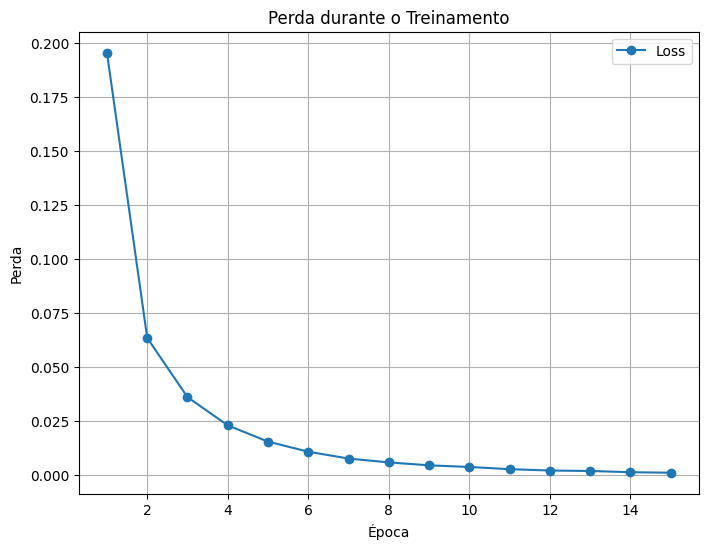

Tempo total de treinamento: 13.31 segundos


In [ ]:
# Treinar o modelo
start_time = time.time()
train(vgg16_fe_top_model, train_preproc_loader, criterion, optimizer, device, epochs=15, binary=True)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo total de treinamento: {elapsed_time:.2f} segundos")

In [ ]:
def evaluate_model(model, dataloader, device, criterion, binary=False):
    """
    Avalia um modelo PyTorch calculando a perda e a acurácia.

    Args:
        model (torch.nn.Module): Modelo a ser avaliado.
        dataloader (torch.utils.data.DataLoader): DataLoader com os dados de validação.
        device (torch.device): Dispositivo (CPU ou GPU).
        criterion (torch.nn.Module): Função de perda (ex: CrossEntropyLoss).

    Returns:
        tuple: Perda média e acurácia em porcentagem.
    """
    model.eval()  # Coloca o modelo em modo de avaliação
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():  # Desativa o cálculo de gradientes
        for inputs, labels in dataloader:
            # Move os dados para o dispositivo
            if binary:
              inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            else:
              inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calcula a perda
            total_loss += loss.item() * inputs.size(0)  # Acumula a perda (ponderada pelo batch size)

            # Predições e contagem de corretos
            if binary:
              predicted = (outputs > 0.5).float()
            else:
              _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Perda média e acurácia
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
# Now we can attach the trained model to the top of the full (frozen) model
vgg16_fe.classifier[3] = vgg16_fe_top_model

avg_loss_val, accuracy_val = evaluate_model(vgg16_fe, val_loader, device, criterion, binary=True)
avg_loss_test, accuracy_test = evaluate_model(vgg16_fe, test_loader, device, criterion, binary=True)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Exibindo os resultados
print(f"Resultados da Validação:")
print(f"  Perda Média: {avg_loss_val}")
print(f"  Acurácia: {accuracy_val}%")

print(f"\nResultados do Teste:")
print(f"  Perda Média: {avg_loss_test}")
print(f"  Acurácia: {accuracy_test}%")

Resultados da Validação:
  Perda Média: 0.01528780009140866
  Acurácia: 99.51749095295537%

Resultados do Teste:
  Perda Média: 0.009583958067559442
  Acurácia: 100.0%


# Fine-tuning

In [ ]:
# Fine-tuning
vgg16_ft = deepcopy(vgg16)

# Substituir as camadas 4, 5 e 6 por uma camada de identidade
vgg16_ft.classifier = nn.Sequential(nn.Identity())

for param in vgg16_ft.parameters():
    param.requires_grad = False

# Verificar a nova arquitetura do classificador
print(vgg16_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_preproc_ft = preprocessed_dataset(vgg16_ft, train_loader)
train_preproc_loader_ft = DataLoader(
    train_preproc_ft, batch_size=16, shuffle=True
)

In [ ]:
vgg16_ft_top_model = nn.Sequential(nn.Linear(25088, 4096),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.5, inplace=False),
                                   nn.Linear(4096, 4096),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.5, inplace=False),
                                   nn.Linear(4096, 2))
vgg16_ft_top_model = vgg16_ft_top_model.to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_ft_top_model.parameters(), lr=0.001)

Epoch 1/15, Loss: 0.4722885042299502, Accuracy: 92.53731343283582%
Epoch 2/15, Loss: 0.35473367870611494, Accuracy: 97.54488427428078%
Epoch 3/15, Loss: 0.5633152962410133, Accuracy: 98.2478909798832%
Epoch 4/15, Loss: 0.563016601060345, Accuracy: 98.66969500324464%
Epoch 5/15, Loss: 0.19602925728263385, Accuracy: 99.41596365996106%
Epoch 6/15, Loss: 0.36167139496433187, Accuracy: 99.27536231884058%
Epoch 7/15, Loss: 0.22643072467718658, Accuracy: 99.54574951330305%
Epoch 8/15, Loss: 0.7288201847787396, Accuracy: 99.25373134328358%
Epoch 9/15, Loss: 0.2514789928201694, Accuracy: 99.64308890330953%
Epoch 10/15, Loss: 1.181552864936928, Accuracy: 99.27536231884058%
Epoch 11/15, Loss: 0.4803060444147817, Accuracy: 99.65390439108803%
Epoch 12/15, Loss: 0.21767860588560622, Accuracy: 99.76205926887303%
Epoch 13/15, Loss: 0.5106090403702622, Accuracy: 99.62145792775254%
Epoch 14/15, Loss: 0.48122375777655285, Accuracy: 99.68635085442354%
Epoch 15/15, Loss: 0.4124054406699758, Accuracy: 99.75

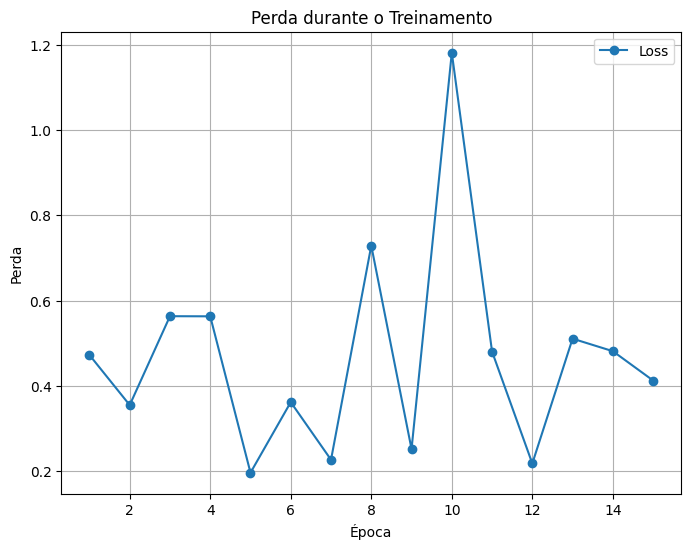

Tempo total de treinamento: 376.74 segundos


In [ ]:
# Treinar o modelo
start_time = time.time()
train(vgg16_ft_top_model, train_preproc_loader_ft, criterion, optimizer, device, epochs=15)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo total de treinamento: {elapsed_time:.2f} segundos")

In [ ]:
# Now we can attach the trained model to the top of the full (frozen) model
vgg16_ft.classifier = vgg16_ft_top_model

avg_loss_val, accuracy_val = evaluate_model(vgg16_ft, val_loader, device, criterion)
avg_loss_test, accuracy_test = evaluate_model(vgg16_ft, test_loader, device, criterion)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Exibindo os resultados
print(f"Resultados da Validação:")
print(f"  Perda Média: {avg_loss_val}")
print(f"  Acurácia: {accuracy_val}%")

print(f"\nResultados do Teste:")
print(f"  Perda Média: {avg_loss_test}")
print(f"  Acurácia: {accuracy_test}%")

Resultados da Validação:
  Perda Média: 0.38006634131271677
  Acurácia: 99.75874547647769%

Resultados do Teste:
  Perda Média: 1.6105498664463933
  Acurácia: 99.2094861660079%


## Segunda etapa do fine-tuning

In [ ]:
vgg16_ft2 = deepcopy(vgg16_ft)
vgg16_ft2_classifier = deepcopy(vgg16_ft2.classifier)

# Modificar a arquitetura
# Remover avgpool e classifier
vgg16_ft2.avgpool = nn.Identity()  # Substitui AdaptiveAvgPool2d por uma identidade
vgg16_ft2.classifier = nn.Identity()  # Remove toda a cabeça da rede (camada fully connected)

# Substituir camada 28 por Identity e remover camadas 29 e 30
modified_features = list(vgg16_ft2.features)
modified_features[28] = nn.Identity()  # Substitui a camada Conv2d na posição 28 por uma identidade
modified_features = modified_features[:29]  # Remove as camadas 28 a 30

# Atualizar o atributo features com as modificações
vgg16_ft2.features = nn.Sequential(*modified_features)

for param in vgg16_ft2.parameters():
    param.requires_grad = False

In [ ]:
vgg16_ft2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16_ft2_top_model = deepcopy(vgg16_ft)

vgg16_ft2_top_model.features = nn.Sequential(
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
)

vgg16_ft2_top_model = vgg16_ft2_top_model.to(device)

In [ ]:
vgg16_ft2_top_model

VGG(
  (features): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=2, bias=True)
  )
)

In [ ]:
def preprocessed_dataset_v2(model, loader, device=None):
    if device is None:
        device = next(model.parameters()).device
    features = None
    labels = None

    for i, (x, y) in enumerate(loader):
        model.eval()
        output = model(x.to(device))
        if i == 0:
            features = output.detach().cpu()
            labels = y.cpu()
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, y.cpu()])

    # Ajustar a forma das features para [batch_size, channels, height, width]
    batch_size, num_features = features.size()
    channels = 512  # Número de canais da camada Conv2d
    height = width = int(math.sqrt(num_features / channels))
    features = features.view(batch_size, channels, height, width)

    dataset = TensorDataset(features, labels)
    return dataset

In [ ]:
train_preproc_ft2 = preprocessed_dataset_v2(vgg16_ft2, train_loader)

In [ ]:
torch.save(train_preproc_ft2.tensors, 'train_preproc_ft2.pth')

In [ ]:
train_preproc_loader_ft2 = DataLoader(
    train_preproc_ft2,
    batch_size=16,
    shuffle=True,
)

In [ ]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_ft2_top_model.parameters(), lr=0.001)

Epoch 1/15, Loss: 23.367746034486444, Accuracy: 91.04477611940298%
Epoch 2/15, Loss: 0.13737051399667158, Accuracy: 97.72874756651525%
Epoch 3/15, Loss: 0.0805066733266865, Accuracy: 98.64806402768765%
Epoch 4/15, Loss: 0.08697138880233897, Accuracy: 98.78866536880814%
Epoch 5/15, Loss: 0.06561143264717485, Accuracy: 99.03742158771361%
Epoch 6/15, Loss: 0.010563442418533159, Accuracy: 99.84858317110101%
Epoch 7/15, Loss: 0.09626633259044687, Accuracy: 98.66969500324464%
Epoch 8/15, Loss: 0.1214983100425674, Accuracy: 98.84274280770063%
Epoch 9/15, Loss: 0.14260755013118523, Accuracy: 98.78866536880814%
Epoch 10/15, Loss: 0.025442415553088564, Accuracy: 99.67553536664504%
Epoch 11/15, Loss: 0.08198074214942226, Accuracy: 99.30780878217608%
Epoch 12/15, Loss: 0.19126848684064987, Accuracy: 99.0590525632706%
Epoch 13/15, Loss: 0.052597031129223114, Accuracy: 99.65390439108803%
Epoch 14/15, Loss: 0.029503332254682116, Accuracy: 99.69716634220204%
Epoch 15/15, Loss: 0.047471512173254064, Ac

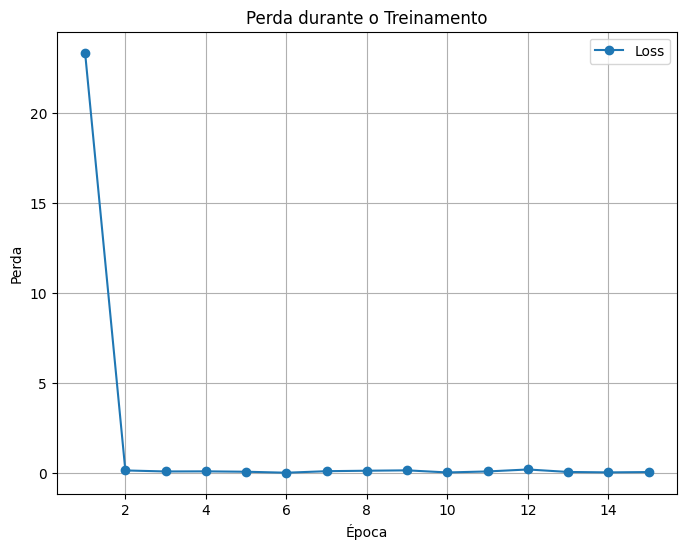

Tempo total de treinamento: 445.15 segundos


In [ ]:
# Treinar o modelo
start_time = time.time()
train(vgg16_ft2_top_model, train_preproc_loader_ft2, criterion, optimizer, device, epochs=15)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo total de treinamento: {elapsed_time:.2f} segundos")

In [ ]:
# Now we can attach the trained model to the top of the full (frozen) model
vgg16_ft2.avgpool = vgg16_ft2_top_model.avgpool
vgg16_ft2.classifier = vgg16_ft2_top_model.classifier

vgg16_ft2.features = nn.Sequential(
    *list(vgg16_ft2.features.children()),
    *list(vgg16_ft2_top_model.features.children()),
)

avg_loss_val, accuracy_val = evaluate_model(vgg16_ft2, val_loader, device, criterion)
avg_loss_test, accuracy_test = evaluate_model(vgg16_ft2, test_loader, device, criterion)

In [ ]:
# Exibindo os resultados
print(f"Resultados da Validação:")
print(f"  Perda Média: {avg_loss_val}")
print(f"  Acurácia: {accuracy_val}%")

print(f"\nResultados do Teste:")
print(f"  Perda Média: {avg_loss_test}")
print(f"  Acurácia: {accuracy_test}%")

Resultados da Validação:
  Perda Média: 0.3695278680402762
  Acurácia: 98.19059107358262%

Resultados do Teste:
  Perda Média: 0.16039800973748297
  Acurácia: 99.2094861660079%
